## Preprocessing

#### paste following lines into anaconda prompt (as admin) and press enter: 
#### conda install -c huggingface -c conda-forge datasets
#### conda install -c anaconda gensim


In [20]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re, string, nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec, FastText
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from imblearn.under_sampling import RandomUnderSampler
from scipy import sparse

# Train test split and class distribution

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vince\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vince\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vince\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\vince\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
Using custom data configuration default
Reusing dataset ag_news (C:\Users\vince\.cache\huggingface\datasets\ag_news\default\0.0.0\bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


  0%|          | 0/2 [00:00<?, ?it/s]

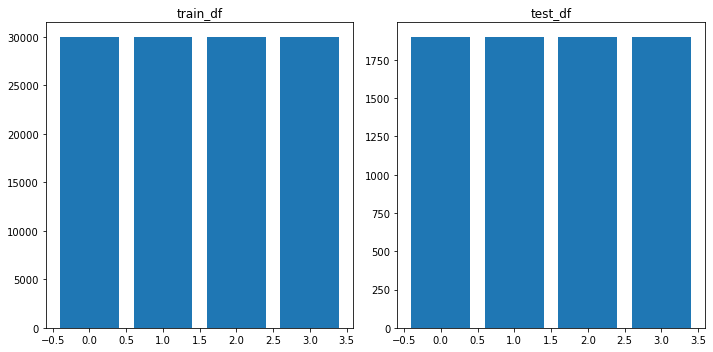

In [2]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# train-test split
dataset = load_dataset("ag_news")
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])
del dataset

def class_distribution():
    
    # checking class distribution
    plt.figure(figsize=(10,5))

    ## train data
    plt.subplot(1,2,1)
    train_df_target = train_df['label']
    class_dist = pd.Series(train_df_target).value_counts()
    plt.title('train_df')
    plt.bar(class_dist.index, class_dist)
    plt.tight_layout()

    ## test data
    plt.subplot(1,2,2)
    test_df_target = test_df['label']
    class_dist = pd.Series(test_df_target).value_counts()
    plt.title('test_df')
    plt.bar(class_dist.index, class_dist)
    plt.tight_layout()

    plt.show()

def balanced_fractionize(df, frac):
    
    frac_df = df.sample(frac=frac, random_state=42)
    frac_data, frac_target = frac_df['text'].values.reshape(-1, 1), frac_df['label'].values.reshape(-1, 1)
    
    sampler = RandomUnderSampler()
    bal_frac_data, bal_frac_target = sampler.fit_resample(frac_data, frac_target)
    
    class_dist = pd.Series(bal_frac_target).value_counts()
    plt.bar(class_dist.index, class_dist)
    plt.ylabel("Frequency")
    plt.show()
    
    return pd.DataFrame(bal_frac_data, columns = ['text']), pd.DataFrame(bal_frac_target, columns = ['label'])

class_distribution()

In [3]:
#initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
wnl = WordNetLemmatizer()


def preprocessing(text):
    
    # convert to lowercase and remove spaces at beginning and ending
    text = text.lower().strip()
    
    # remove punctuation
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    
    # remove html code
    text= re.sub('<.*?>', '', text) 
    
    # remove special characters
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    
    # remove digits
    text = re.sub(r'\d',' ',text)
    
    # replace multiple whitespaces with one
    text = re.sub('\s+', ' ', text)
    
    # stop word removal
    clean_text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # tonkenize & lemmatize
    word_pos_tags = nltk.pos_tag(word_tokenize(clean_text)) # -> list of tuples (word, pos_tag) [('computer', 'NN'), ('word', 'tag')]
    lem_text = ' '.join([wnl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for tag in word_pos_tags])

    return lem_text

 
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        # default pos
        return wordnet.NOUN
    


In [5]:
# execute preprocessing for training set
train_df['text'] = train_df['text'].apply(lambda x: preprocessing(x))
train_df.to_csv('training_data.csv', sep=';', encoding='utf-8', index=False)
train_df.head()

,text,label
0,wall st bear claw back black reuters reuters s...,2
1,carlyle look toward commercial aerospace reute...,2
2,oil economy cloud stock outlook reuters reuter...,2
3,iraq halt oil export main southern pipeline re...,2
4,oil price soar time record pose new menace u e...,2


## Vectorization

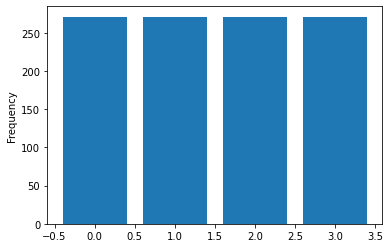

In [4]:
# read in preprocessed training data if necessary
train_df = pd.read_csv('preprocessed_training_data.csv', sep=';', encoding='utf-8')

#fractionize and undersample data
train_data, train_target = balanced_fractionize(train_df, 0.01)


# for word embedding models
train_tokens = [word_tokenize(text) for text in train_data['text']]




### Count vectors and Tf-idf vectors

In [38]:
tfidf_vectorizer = TfidfVectorizer()
count_vectorizer = CountVectorizer()
tfidf_vectors = tfidf_vectorizer.fit_transform(train_data['text'])
count_vectors = count_vectorizer.fit_transform(train_data['text'])

### Word2Vec SkipGram & CBOW

In [6]:
w2v_cbow = Word2Vec(train_tokens, min_count=2,vector_size=300, window=5)
w2v_skipg = Word2Vec(train_tokens, min_count=2,vector_size=300, window=5, sg = 1)

In [7]:
# returns mean w2v vector for list of specified words
def get_embedding(model, text):
    existing_words = [word for word in text if word in list(model.wv.index_to_key)]
    if existing_words:
        embedding = np.zeros((len(existing_words), model.vector_size), dtype=np.float32)
        for i, w in enumerate(existing_words):
                embedding[i] = model.wv[w]
        return np.mean(embedding, axis=0)
    else:
        return np.zeros(model.vector_size)

In [36]:
# get mean vector for each article description for both models
embeddings_w2v_cbow = sparse.csr_matrix( np.array([get_embedding(w2v_cbow, text) for text in train_tokens]) )
embeddings_w2v_skipg = sparse.csr_matrix( np.array([get_embedding(w2v_skipg, text) for text in train_tokens]) )

### fastText

In [9]:
fasttext = FastText(vector_size=300, window=5, min_count=2)
fasttext.build_vocab(corpus_iterable=train_tokens)
fasttext.train(corpus_iterable=train_tokens, total_examples=len(train_tokens), epochs=10)

(245163, 281410)

In [40]:
embeddings_fasttext = sparse.csr_matrix( np.array([get_embedding(fasttext, text) for text in train_tokens]) )

## Classification

### Hyperparameter Tuning

In [44]:
# hyperparameter tuning
def param_search(vector_matrix, vector_matrix_name, estimator):
    
    estimator_name = estimator['name']
    parameters = estimator['parameters']
    estimator = estimator['estimator']
    
    # specify the cross validation
    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    
    # specify the nested cross validation
    nested_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    # create the grid search instance
    search = GridSearchCV(estimator, parameters, scoring='accuracy', cv=nested_cv, n_jobs=-1)
    
    # run the grid search
    cross_val_acc = cross_val_score(search, vector_matrix.toarray(), np.ravel(train_target,order='C'), scoring='accuracy', cv=cv)
    accuracy = cross_val_acc.mean()
    
    # print the best parameter setting
    print("Classifier: {}".format(estimator_name))
    print("Vectorizer: {}".format(vector_matrix_name))
    print("Accuracy: {}".format(accuracy))
    print()
    
    return accuracy, search

In [45]:
# tune for the best vectorizer-estimator combination
def hyper_tune():
    
    kNeighbors_parameters = {
        'leaf_size': range(25,35),
        'n_neighbors': range(2, 9)
    }
    
    decisionTree_parameters = {
        'criterion':['gini', 'entropy'], 
        'max_depth':[ 2, 3, 4, 5, None]
    }
    
    gaussianNB_parameters = {
        'var_smoothing': [np.logspace(0,-9, num=10)]
    }
    
    svc_parameters = {
        'C': [0.1, 1.0, 10.0],
        'gamma': ['auto', 'scale', 'float'],
        'kernel': ['rbf', 'poly', 'sigmoid']
    }
    
    mlpClassifier_parameters = {
        'learning_rate': ['constant', 'adaptive'],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam']
    }
    
    #TODO: add the other matrices, when done
    vectorizers = {
        'tfidf_vectors': tfidf_vectors,
        'count_vectors': count_vectors,
        'w2v_cbow': embeddings_w2v_cbow,
        'w2v_skipg': embeddings_w2v_skipg,
        'fasttext': embeddings_fasttext
            
    }
    
    #TODO: add more estimators
    estimators = {
        'KNeighborsClassifier': { 'name': 'KNeighborsClassifier', 'estimator': KNeighborsClassifier(), 'parameters': kNeighbors_parameters }#,
#         'DecisionTreeClassifier': { 'name': 'DecisionTreeClassifier', 'estimator': DecisionTreeClassifier(), 'parameters': decisionTree_parameters },
#         'GaussianNB': { 'name': 'GaussianNB', 'estimator': GaussianNB(), 'parameters': gaussianNB_parameters },
#         'SVC': { 'name': 'SVC', 'estimator': SVC(), 'parameters': svc_parameters },
#         'MLPClassifier': { 'name': 'MLPClassifier', 'estimator': MLPClassifier(), 'parameters': mlpClassifier_parameters }
    }
    
    best_score = 0
    for vectorizer in vectorizers:
        for estimator in estimators:
            
            score, model = param_search( vectorizers[vectorizer], vectorizer, estimators[estimator] )
            if score > best_score:
                best_score = score
                best_estimator = estimator
                best_vectorizer = vectorizer
                best_model = model

    print("\nThe best performance is reached with the estimator " + best_estimator + " and the vectorizer " + best_vectorizer + " with an accuracy of " + str(best_score) )
    return best_model
model = hyper_tune()

Classifier: KNeighborsClassifier
Vectorizer: tfidf_vectors
Accuracy: 0.7739852398523985

Classifier: KNeighborsClassifier
Vectorizer: count_vectors
Accuracy: 0.4704797047970479

Classifier: KNeighborsClassifier
Vectorizer: w2v_cbow
Accuracy: 0.37084870848708484

Classifier: KNeighborsClassifier
Vectorizer: w2v_skipg
Accuracy: 0.41697416974169743

Classifier: KNeighborsClassifier
Vectorizer: fasttext
Accuracy: 0.2859778597785978


The best performance is reached with the estimator KNeighborsClassifier and the vectorizer tfidf_vectors with an accuracy of 0.7739852398523985
